# 1.2 Visualize the Optimization Process

## Import libraries

In [24]:
### Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cpu


## Define and Plot Function

In [3]:
def fn(x):
    return torch.sin(5*torch.pi*x)/(5*torch.pi*x)

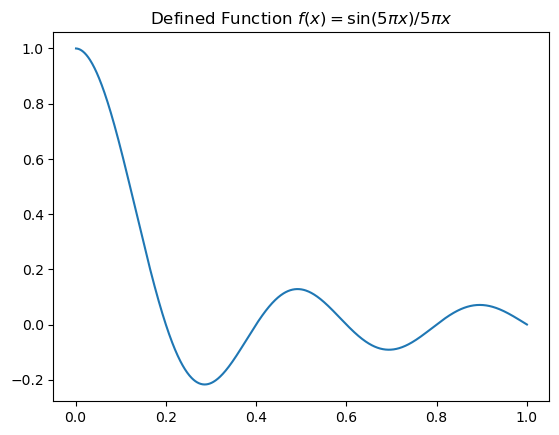

In [4]:
### Plot fn
xvec = torch.linspace(0,1,1000)
yvec = fn(xvec)
plt.plot(xvec,yvec, label = "function")
plt.title("Defined Function $f(x)=\sin(5\pi x)/5\pi x$")
plt.show()

## Load Data

In [5]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transforms.ToTensor())

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)


## View Image

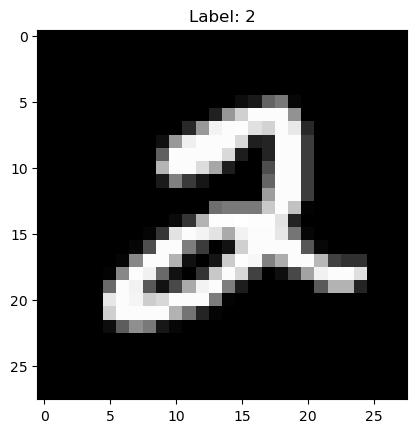

In [6]:
# Choose an image index
image_index = 5  # You can change this to any valid index

# Get the image and label
image, label = train_dataset[image_index]

# Convert the image tensor to a numpy array
image_array = image.numpy()

# Reshape the array to 28x28
image_array = image_array.reshape(28, 28)

# Display the image
plt.imshow(image_array, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

## Define Model Class

In [10]:
class model_class(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=None):
        super(model_class, self).__init__()

        # Store model architecture parameters
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes or []

        # Create layers
        layers = []
        in_features = input_size
        for h_size in hidden_sizes:
            layers.append(nn.Linear(in_features, h_size))
            layers.append(nn.ReLU())  # Add activation after each hidden layer
            in_features = h_size
        layers.append(nn.Linear(in_features, output_size))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        # Forward pass through the layers
        x = x.view(-1, 784)
        for layer in self.layers:
            x = layer(x)
        return x

## Train & Eval Function
### With collecting model params

In [28]:
### training function
def train_eval(model, num_epochs, learning_rate, train_loader, test_loader):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Training loop
    total_loss = []
    total_accuracy = []
    model_weights = pd.DataFrame()
    for epoch in range(num_epochs):
        train_loss = 0.0

        #Training
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            #print(images.shape, labels.shape)

            # Zero out Gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            train_loss += loss * images.size(0)

        train_loss = train_loss/len(train_loader.sampler)
        total_loss.append(train_loss)
        print(f"train loss: {train_loss}")

        # Collect parameters
        #weights = [p.data.clone() for p in model.parameters()]
        temp_wts = pd.DataFrame()
        for name, parameter in model.named_parameters():
            if 'weight' in name:
                weights = torch.nn.utils.parameters_to_vector(parameter).detach().numpy()
                temp_wts = pd.concat([temp_wts, pd.DataFrame(weights).T], axis = 1)
        model_weights = pd.concat([model_weights,temp_wts], axis = 0)
        
        #Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        total_accuracy.append(accuracy)
        #print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
    return total_loss, total_accuracy, model_weights

## Specify Model

In [29]:
model1 = model_class(input_size = 784, output_size = 10, hidden_sizes = [17, 26, 25, 23, 12])

## Train Model

In [30]:
#m1_loss, m1_acc, m1_weights = train_eval(model1, num_epochs=2, learning_rate=0.001, train_loader=train_loader
#                             , test_loader=test_loader)

train loss: 0.6640022397041321
Accuracy of the network on the 10000 test images: 89.44 %
train loss: 0.3324921429157257
Accuracy of the network on the 10000 test images: 91.27 %


In [31]:
##m1_weights.head()
#wts = np.array(m1_weights)

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.017343,0.021597,0.014921,-0.006585,0.02876,-0.015732,-0.02706,0.008684,0.025726,0.010219,...,0.310360,0.212175,-0.463013,-0.086952,-0.054553,-0.310401,-0.168169,-0.198375,-0.051436,-0.075317
0,0.017343,0.021597,0.014921,-0.006585,0.02876,-0.015732,-0.02706,0.008684,0.025726,0.010219,...,0.337829,0.183253,-0.523511,-0.100517,-0.039485,-0.356180,-0.123563,-0.203787,0.033116,-0.178729


In [68]:
# check model parameter number
model1_parameters = []
for name, param in model1.named_parameters():
    if 'weight' in name:
        model1_parameters.append(param.T.shape[0])
print(model1_parameters)
sum = 0
for l in range(0,len(model1_parameters)-1):
    sum += model1_parameters[l] * model1_parameters[l+1]
sum += model1_parameters[-1]*10 # last output layer
print(sum)

[784, 17, 26, 25, 23, 12]
15391


In [79]:
'''df_temp = m1_weights.copy()
df_temp['loss'] = np.array([x.detach().numpy() for x in m1_loss])
df_temp['accuracy'] = m1_acc
df_temp.head()'''

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,loss,accuracy
0,0.017343,0.021597,0.014921,-0.006585,0.02876,-0.015732,-0.02706,0.008684,0.025726,0.010219,...,-0.463013,-0.086952,-0.054553,-0.310401,-0.168169,-0.198375,-0.051436,-0.075317,0.664002,89.44
0,0.017343,0.021597,0.014921,-0.006585,0.02876,-0.015732,-0.02706,0.008684,0.025726,0.010219,...,-0.523511,-0.100517,-0.039485,-0.356180,-0.123563,-0.203787,0.033116,-0.178729,0.332492,91.27


In [80]:
df = pd.DataFrame()
for i in range(8):
    model1 = model_class(input_size = 784, output_size = 10, hidden_sizes = [17, 26, 25, 23, 12])
    m1_loss, m1_acc, m1_weights = train_eval(model1, num_epochs=2, learning_rate=0.001, train_loader=train_loader
                             , test_loader=test_loader)
    df_temp = m1_weights.copy()
    df_temp['loss'] = np.array([x.detach().numpy() for x in m1_loss])
    df_temp['accuracy'] = m1_acc
    df = pd.concat([df, df_temp], axis = 0).reset_index(drop = True)
df.head()

train loss: 0.2571801245212555
Accuracy of the network on the 10000 test images: 93.23 %
train loss: 0.20939746499061584
Accuracy of the network on the 10000 test images: 93.57 %
train loss: 0.18219339847564697
Accuracy of the network on the 10000 test images: 94.2 %
train loss: 0.16476981341838837
Accuracy of the network on the 10000 test images: 94.81 %
train loss: 0.149832621216774
Accuracy of the network on the 10000 test images: 95.0 %
train loss: 0.14158986508846283
Accuracy of the network on the 10000 test images: 94.74 %
train loss: 0.13468340039253235
Accuracy of the network on the 10000 test images: 95.36 %
train loss: 0.12705406546592712
Accuracy of the network on the 10000 test images: 95.51 %


,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,loss,accuracy
0,0.017343,0.021597,0.014921,-0.006585,0.02876,-0.015732,-0.02706,0.008684,0.025726,0.010219,...,-0.558520,-0.100501,-0.047621,-0.413670,-0.064728,-0.229805,0.101267,-0.285421,0.257180,93.23
0,0.017343,0.021597,0.014921,-0.006585,0.02876,-0.015732,-0.02706,0.008684,0.025726,0.010219,...,-0.557422,-0.088170,-0.054533,-0.428586,-0.031430,-0.231582,0.119042,-0.324494,0.209397,93.57
0,0.017343,0.021597,0.014921,-0.006585,0.02876,-0.015732,-0.02706,0.008684,0.025726,0.010219,...,-0.582945,-0.076817,-0.072785,-0.430289,-0.011333,-0.245560,0.118550,-0.341482,0.182193,94.20
0,0.017343,0.021597,0.014921,-0.006585,0.02876,-0.015732,-0.02706,0.008684,0.025726,0.010219,...,-0.587449,-0.066124,-0.070309,-0.442130,0.002712,-0.254366,0.136813,-0.375111,0.164770,94.81
0,0.017343,0.021597,0.014921,-0.006585,0.02876,-0.015732,-0.02706,0.008684,0.025726,0.010219,...,-0.603654,-0.062047,-0.065150,-0.435915,0.006565,-0.258229,0.147387,-0.365457,0.149833,95.00


Add Accuracy and Loss columns to the weights data frame.

## PCA

In [86]:
df_pca = df.drop(["loss", "accuracy"], axis = 1).reset_index(drop = True)
print(df_pca.shape)
df_pca.head()

(8, 15391)


,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.017343,0.021597,0.014921,-0.006585,0.02876,-0.015732,-0.02706,0.008684,0.025726,0.010219,...,0.389454,0.182763,-0.558520,-0.100501,-0.047621,-0.413670,-0.064728,-0.229805,0.101267,-0.285421
1,0.017343,0.021597,0.014921,-0.006585,0.02876,-0.015732,-0.02706,0.008684,0.025726,0.010219,...,0.414576,0.174189,-0.557422,-0.088170,-0.054533,-0.428586,-0.031430,-0.231582,0.119042,-0.324494
2,0.017343,0.021597,0.014921,-0.006585,0.02876,-0.015732,-0.02706,0.008684,0.025726,0.010219,...,0.442167,0.161141,-0.582945,-0.076817,-0.072785,-0.430289,-0.011333,-0.245560,0.118550,-0.341482
3,0.017343,0.021597,0.014921,-0.006585,0.02876,-0.015732,-0.02706,0.008684,0.025726,0.010219,...,0.455983,0.163614,-0.587449,-0.066124,-0.070309,-0.442130,0.002712,-0.254366,0.136813,-0.375111
4,0.017343,0.021597,0.014921,-0.006585,0.02876,-0.015732,-0.02706,0.008684,0.025726,0.010219,...,0.470546,0.170806,-0.603654,-0.062047,-0.065150,-0.435915,0.006565,-0.258229,0.147387,-0.365457


In [87]:
df_pca = np.array(df_pca)
pca = PCA(n_components=2)
new_data = pca.fit_transform(df_pca)

In [104]:

df_full = pd.DataFrame(new_data, columns=['x','y'])
df_full['Accuracy'] = df['accuracy'].reset_index(drop = True)
df_full['Loss'] = df['loss'].reset_index(drop = True)
#df_full.head()
df_full = df_full.iloc[::3, :]

,x,y,Accuracy,Loss
0,7.723472,1.960246,93.23,0.257180
1,5.514707,0.130707,93.57,0.209397
2,2.950107,-1.244811,94.20,0.182193
3,0.669537,-1.606986,94.81,0.164770
4,-1.667408,-1.228763,95.00,0.149833


93.23
93.57
94.2
94.81


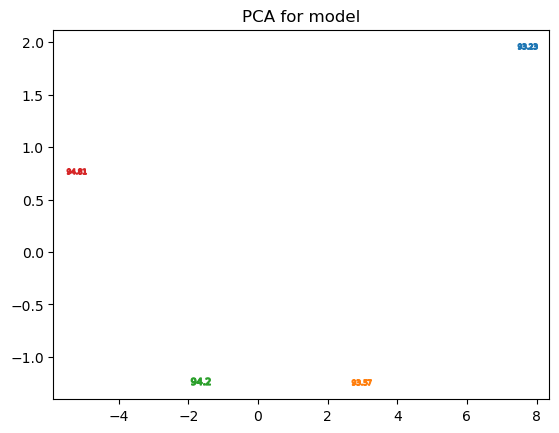

In [112]:
for i in range(120):
    m = list(df_full['Accuracy'])[i]
    plt.scatter(df_full['x'][i*3], df_full['y'][i*3], s = 200, marker = f'${m}$')
    plt.title("PCA for model")

In [20]:
'''
epoch_ct = 0
for epoch in m1_weights:
    event_ct = 0
    for event in epoch:
        print(f"epoch {epoch_ct}, event {event_ct}; is size {event.shape}")
        event_ct += 1
    epoch_ct += 1
'''

epoch 0, event 0; is size (13328,)
epoch 0, event 1; is size (442,)
epoch 0, event 2; is size (650,)
epoch 0, event 3; is size (575,)
epoch 0, event 4; is size (276,)
epoch 0, event 5; is size (120,)
epoch 1, event 0; is size (13328,)
epoch 1, event 1; is size (442,)
epoch 1, event 2; is size (650,)
epoch 1, event 3; is size (575,)
epoch 1, event 4; is size (276,)
epoch 1, event 5; is size (120,)


## Gradient Norm

In [126]:
def gradient_norm(model):
    grad_all = 0.0
    for p in model.parameters():
        grad = 0.0 
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy() ** 2).sum()
        grad_all += grad

    grad_norm = grad_all ** 0.5
    return grad_norm

## Train & Eval Function
### With gradient norm function

In [ ]:
### training function for MNIST data set
def train_eval(model, num_epochs, learning_rate, train_loader, test_loader):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Training loop
    total_loss = []
    total_accuracy = []
    gradient = []
    for epoch in range(num_epochs):
        train_loss = 0.0

        #Training
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            #print(images.shape, labels.shape)

            # Zero out Gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            train_loss += loss * images.size(0)

        train_loss = train_loss/len(train_loader.sampler)
        total_loss.append(train_loss)
        gradient.append(gradient_norm(model))
        print(f"train loss: {train_loss}")

        #Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        total_accuracy.append(accuracy)
        print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
    return total_loss, total_accuracy, gradient

In [ ]:
### Training function for training on fn(x)
def train_model(model, X_train, Y_train, batch, epochs, learning_rate):
  # send data to device
  X_train, Y_train = X_train.to(device), Y_train.to(device)

  # load training data for model 1
  data_loader = DataLoader(TensorDataset(X_train,Y_train), batch_size=batch, shuffle = True)

  # Create optimizer and loss function
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  loss_fn = nn.MSELoss()
  
  # Send model to device
  model.to(device)

  # Training loop for model 1
  loss_vec = []
  gradient = []
  for epoch in range(epochs):
      epoch_loss = 0.0
      for i,data in enumerate(data_loader):
          x_batch, y_batch = data
          optimizer.zero_grad()
      #print(x_train.shape)
          y_pred = model(x_batch)
          loss = loss_fn(y_pred, y_batch)
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
      loss_vec.append(epoch_loss)
      gradient.append(gradient_norm(model))
  return loss_vec, gradient

In [ ]:
model1 = model_class(input_size = 784, output_size = 10, hidden_sizes = [17, 26, 25, 23, 12])

In [ ]:
### Train on MNIST
m1_loss, m1_acc, m1_grad = train_eval(model1, num_epochs=2, learning_rate=0.001, train_loader=train_loader
                             , test_loader=test_loader)

In [ ]:
### Train on fn(x)
x_train = torch.linspace(0,1,1000)
y_train = fn(x_train)
# Train the model
model1_loss, model1_grad = train_model(model1, x_train, y_train, batch = 50, epochs = 10, learning_rate = 0.001)